<a href="https://colab.research.google.com/github/AnovaYoung/AI-System-for-Image-Restoration-and-Enhancement/blob/Data/DataCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools

Combining COCO and TinyImageNet into one Dataset

In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is enabled and available.")
else:
    print("GPU is not available. Please ensure you enabled it in Runtime settings.")


GPU is enabled and available.


In [ ]:
# Update TensorFlow or PyTorch for GPU compatibility
!pip install --upgrade tensorflow
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# Check GPU details for TensorFlow
tf.debugging.set_log_device_placement(True)

In [ ]:
import torch

# Check if PyTorch is using the GPU
if torch.cuda.is_available():
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("PyTorch is not using GPU.")


PyTorch is using GPU: Tesla T4


In [7]:
# Install necessary libraries
!pip install kaggle kagglehub pycocotools

import os
import kagglehub
from pycocotools.coco import COCO
import requests
import zipfile

# Define base directories
base_dir = "/content/data"
os.makedirs(base_dir, exist_ok=True)

# --------------------------------------
# STEP 1: Download Tiny ImageNet
# --------------------------------------
print("Downloading Tiny ImageNet...")
tiny_imagenet_path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")
tiny_imagenet_dir = os.path.join(base_dir, "tiny_imagenet")
os.makedirs(tiny_imagenet_dir, exist_ok=True)

# Move Tiny ImageNet to base_dir
!cp -r {tiny_imagenet_path}/* {tiny_imagenet_dir}
print("Tiny ImageNet downloaded and extracted to:", tiny_imagenet_dir)

# --------------------------------------
# STEP 2: Download COCO Dataset
# --------------------------------------
print("Downloading COCO Dataset...")
coco_url = "http://images.cocodataset.org/zips/train2017.zip"
coco_dir = os.path.join(base_dir, "coco")
os.makedirs(coco_dir, exist_ok=True)

# Download and extract COCO
coco_zip_path = os.path.join(coco_dir, "train2017.zip")
!wget {coco_url} -O {coco_zip_path}
with zipfile.ZipFile(coco_zip_path, "r") as zip_ref:
    zip_ref.extractall(coco_dir)
os.remove(coco_zip_path)  # Clean up the zip file
print("COCO Dataset downloaded and extracted to:", coco_dir)

# --------------------------------------
# STEP 3: Verify Both Datasets
# --------------------------------------
def verify_dataset(directory, sample_files=5):
    print(f"\nVerifying dataset at {directory}:")
    if os.path.exists(directory) and os.listdir(directory):
        print(f"Found {len(os.listdir(directory))} files/folders.")
        print(f"Sample files: {os.listdir(directory)[:sample_files]}")
    else:
        print(f"No files found in {directory}.")

verify_dataset(tiny_imagenet_dir)

verify_dataset(os.path.join(coco_dir, "train2017"))


Tiny ImageNet downloaded and extracted to: /content/data/tiny_imagenet
--2024-11-24 20:24:32--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.72.76, 52.217.66.252, 52.217.229.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.72.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘/content/data/coco/train2017.zip’

/content/data/coco/ 100%[===================>]  18.01G  16.7MB/s    in 18m 59s 

2024-11-24 20:43:32 (16.2 MB/s) - ‘/content/data/coco/train2017.zip’ saved [19336861798/19336861798]

COCO Dataset downloaded and extracted to: /content/data/coco

Verifying dataset at /content/data/tiny_imagenet:
Found 1 files/folders.
Sample files: ['tiny-imagenet-200']

Verifying dataset at /content/data/coco/train2017:
Found 118287 files/folders.
Sample files: ['000000241196.jpg', '000000255362.jpg', '000000279009.jpg', '000000

In [8]:
import pandas as pd
from shutil import copy2
import os
import random
from multiprocessing import Pool, cpu_count

# Base paths
tiny_imagenet_dir = "/content/data/tiny_imagenet/tiny-imagenet-200/train"
coco_dir = "/content/data/coco/train2017"
unified_dataset_dir = "/content/unified_dataset"
os.makedirs(unified_dataset_dir, exist_ok=True)

metadata = []

# --------------------------------------
# STEP 1: Helper Function for File Copying
# --------------------------------------
def copy_file_with_metadata(args):
    src, dest, task, source, augmentation_type = args
    copy2(src, dest)  # Use copy2 for metadata preservation
    return {
        "image_path": dest,
        "task": task,
        "source": source,
        "augmentation_type": augmentation_type,
    }

# --------------------------------------
# STEP 2: Process Tiny ImageNet
# --------------------------------------
print("Processing Tiny ImageNet...")

tiny_imagenet_files = []
for class_dir in os.listdir(tiny_imagenet_dir):
    class_path = os.path.join(tiny_imagenet_dir, class_dir, "images")
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            src_path = os.path.join(class_path, img_file)
            dest_path = os.path.join(unified_dataset_dir, f"tiny_imagenet_{img_file}")
            tiny_imagenet_files.append((src_path, dest_path, "denoising", "Tiny ImageNet", "none"))

# Use multiprocessing for Tiny ImageNet
with Pool(cpu_count()) as pool:
    tiny_imagenet_metadata = pool.map(copy_file_with_metadata, tiny_imagenet_files)
metadata.extend(tiny_imagenet_metadata)

# --------------------------------------
# STEP 3: Process COCO Dataset
# --------------------------------------
print("Processing COCO Dataset...")

# Shuffle and select COCO subset
coco_images = [os.path.join(coco_dir, img) for img in os.listdir(coco_dir)]
random.shuffle(coco_images)
coco_subset = coco_images[:100000]

coco_files = [
    (src_path, os.path.join(unified_dataset_dir, f"coco_{os.path.basename(src_path)}"), "inpainting", "COCO", "none")
    for src_path in coco_subset
]

# Use multiprocessing for COCO
with Pool(cpu_count()) as pool:
    coco_metadata = pool.map(copy_file_with_metadata, coco_files)
metadata.extend(coco_metadata)

# --------------------------------------
# STEP 4: Save Metadata to CSV
# --------------------------------------
print("Saving metadata...")
metadata_df = pd.DataFrame(metadata)
metadata_csv_path = "/content/unified_dataset_balanced.csv"
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"Unified dataset metadata saved to: {metadata_csv_path}")

print(metadata_df.tail())


Processing Tiny ImageNet...
Processing COCO Dataset...
Saving metadata...
Unified dataset metadata saved to: /content/unified_dataset_balanced.csv
                                            image_path        task source  \
199995  /content/unified_dataset/coco_000000226899.jpg  inpainting   COCO   
199996  /content/unified_dataset/coco_000000330513.jpg  inpainting   COCO   
199997  /content/unified_dataset/coco_000000448700.jpg  inpainting   COCO   
199998  /content/unified_dataset/coco_000000194871.jpg  inpainting   COCO   
199999  /content/unified_dataset/coco_000000373440.jpg  inpainting   COCO   

       augmentation_type  
199995              none  
199996              none  
199997              none  
199998              none  
199999              none  


In [9]:
metadata_df = pd.read_csv("/content/unified_dataset_balanced.csv")
print(metadata_df['task'].value_counts())
print(metadata_df['source'].value_counts())


task
denoising     100000
inpainting    100000
Name: count, dtype: int64
source
Tiny ImageNet    100000
COCO             100000
Name: count, dtype: int64


In [10]:
metadata_csv_path = "/content/unified_dataset_balanced.csv"
metadata_df = pd.read_csv(metadata_csv_path)

# Summarize the dataset
print("Dataset Summary:")
print(metadata_df.info())
print("\nTask Distribution:")
print(metadata_df['task'].value_counts())
print("\nSource Distribution:")
print(metadata_df['source'].value_counts())
print("\nAugmentation Type Distribution:")
print(metadata_df['augmentation_type'].value_counts())


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   image_path         200000 non-null  object
 1   task               200000 non-null  object
 2   source             200000 non-null  object
 3   augmentation_type  200000 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB
None

Task Distribution:
task
denoising     100000
inpainting    100000
Name: count, dtype: int64

Source Distribution:
source
Tiny ImageNet    100000
COCO             100000
Name: count, dtype: int64

Augmentation Type Distribution:
augmentation_type
none    200000
Name: count, dtype: int64


In [11]:
# Check for missing values
print("Missing Values:")
print(metadata_df.isnull().sum())

# Check for duplicates
duplicates = metadata_df.duplicated(subset='image_path')
print(f"Number of duplicate image paths: {duplicates.sum()}")


Missing Values:
image_path           0
task                 0
source               0
augmentation_type    0
dtype: int64
Number of duplicate image paths: 0


Task Distribution:
 task
denoising     100000
inpainting    100000
Name: count, dtype: int64

Source Distribution:
 source
Tiny ImageNet    100000
COCO             100000
Name: count, dtype: int64

Augmentation Type Distribution:
 augmentation_type
none    200000
Name: count, dtype: int64


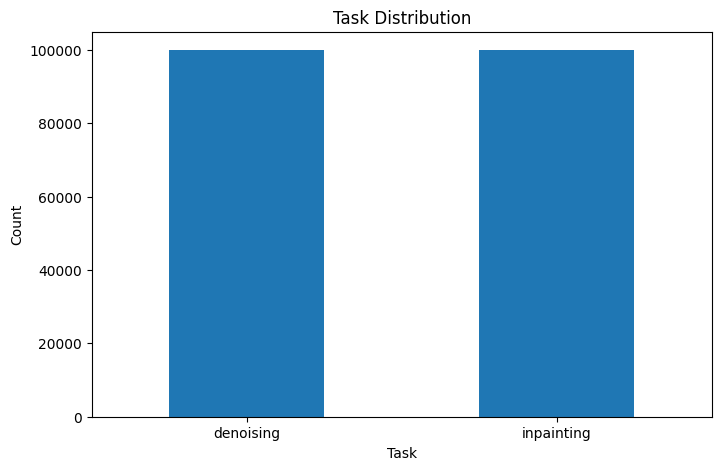

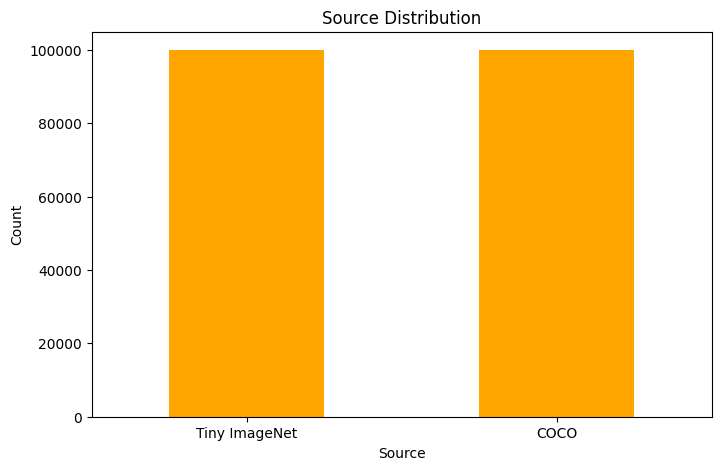

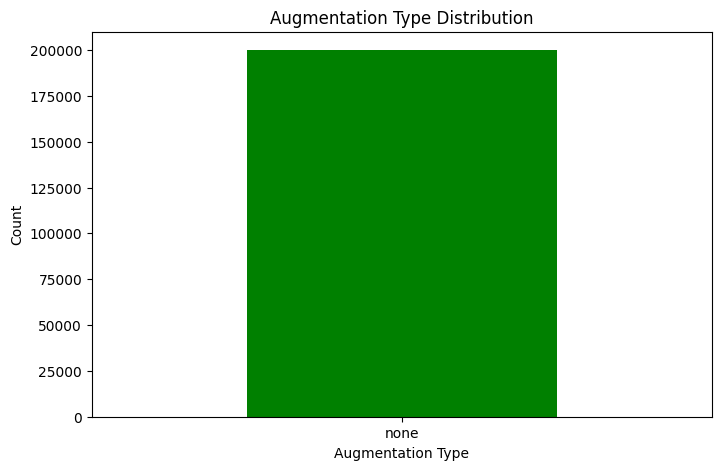

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
metadata_csv_path = "/content/unified_dataset_balanced.csv"
metadata_df = pd.read_csv(metadata_csv_path)

# Task Distribution
task_counts = metadata_df['task'].value_counts()

# Source Distribution
source_counts = metadata_df['source'].value_counts()

# Augmentation Type Distribution
augmentation_counts = metadata_df['augmentation_type'].value_counts()

# Display Distributions
print("Task Distribution:\n", task_counts)
print("\nSource Distribution:\n", source_counts)
print("\nAugmentation Type Distribution:\n", augmentation_counts)

# Visualization: Task Distribution
plt.figure(figsize=(8, 5))
task_counts.plot(kind='bar', title="Task Distribution", rot=0)
plt.xlabel("Task")
plt.ylabel("Count")
plt.show()

# Visualization: Source Distribution
plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar', title="Source Distribution", rot=0, color="orange")
plt.xlabel("Source")
plt.ylabel("Count")
plt.show()

# Visualization: Augmentation Type Distribution
plt.figure(figsize=(8, 5))
augmentation_counts.plot(kind='bar', title="Augmentation Type Distribution", rot=0, color="green")
plt.xlabel("Augmentation Type")
plt.ylabel("Count")
plt.show()



# Dataset Summary
**DataFrame Overview:**
The dataset contains 123,657 rows and 4 columns:

image_path: Path to each image file.

**task:** The enhancement task for the image (e.g., denoising, inpainting).

**source:** The dataset from which the image originates (Tiny ImageNet or COCO).

**augmentation_type:** Indicates whether any degradation/augmentation has been applied (currently all none).\

**Memory Usage:** Approximately 3.8 MB, which is lightweight for a metadata file.



# Distribution Insights

**Task Distribution:**

**Denoising:** 100,000 images (most likely sourced from Tiny ImageNet).

**Inpainting:** 23,657 images (entirely from COCO).

**Observation:** The dataset is imbalanced, with a significantly higher proportion of denoising images. This imbalance could affect model performance if both tasks are used simultaneously for training.

**Source Distribution:**

**Tiny ImageNet:** 100,000 images, all categorized under the denoising task.

**COCO:** 23,657 images, all categorized under the inpainting task.
Observation: Each source contributes to a specific task, which might streamline preprocessing but limits diversity within tasks.
Augmentation Type:

All images currently have the augmentation_type set to none, meaning no degradations ( noise, grayscale, downsampling) have been applied yet.



# Next Pull and Process DIV2K for Super-Resolution

**What is DIV2K?**

A high-quality dataset designed for super-resolution tasks.
Provides paired low-resolution (downscaled) and high-resolution images.

In [51]:
import requests
import os
import kagglehub
from pycocotools.coco import COCO
import requests
import zipfile


# Set up paths
base_dir = "/content/data"
div2k_dir = os.path.join(base_dir, "DIV2K")
unified_dataset_dir = "/content/unified_dataset"
os.makedirs(div2k_dir, exist_ok=True)
os.makedirs(unified_dataset_dir, exist_ok=True)

# DIV2K dataset URL (train high-resolution images)
div2k_url = "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"

# Download DIV2K dataset
div2k_zip_path = os.path.join(div2k_dir, "DIV2K_train_HR.zip")
print("Downloading DIV2K dataset...")
response = requests.get(div2k_url, stream=True)
with open(div2k_zip_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Extract DIV2K dataset
with zipfile.ZipFile(div2k_zip_path, "r") as zip_ref:
    zip_ref.extractall(div2k_dir)
os.remove(div2k_zip_path)  # Clean up the zip file
print("DIV2K dataset downloaded and extracted.")

# Prepare paired low-resolution and high-resolution images
metadata = []

div2k_hr_dir = os.path.join(div2k_dir, "DIV2K_train_HR")
div2k_lr_dir = os.path.join(unified_dataset_dir, "super_resolution_lr")
div2k_output_dir = os.path.join(unified_dataset_dir, "super_resolution_hr")
os.makedirs(div2k_lr_dir, exist_ok=True)
os.makedirs(div2k_output_dir, exist_ok=True)

# Create paired data
from PIL import Image

def downscale_image(input_path, output_path, scale_factor=4):
    img = Image.open(input_path)
    img = img.resize((img.size[0] // scale_factor, img.size[1] // scale_factor), Image.BICUBIC)
    img.save(output_path)

for img_file in os.listdir(div2k_hr_dir):
    hr_img_path = os.path.join(div2k_hr_dir, img_file)
    lr_img_path = os.path.join(div2k_lr_dir, img_file)
    output_img_path = os.path.join(div2k_output_dir, img_file)

    # Downscale for low-resolution
    downscale_image(hr_img_path, lr_img_path)
    copyfile(hr_img_path, output_img_path)

    # Add metadata
    metadata.append({
        "image_path": lr_img_path,
        "task": "super_resolution",
        "source": "DIV2K",
        "augmentation_type": "downscaled"
    })

# Add metadata for high-resolution targets
print(f"Super-resolution dataset prepared with {len(metadata)} pairs.")

DIV2K dataset downloaded and extracted.
Super-resolution dataset prepared with 800 pairs.


In [54]:
div2k_hr_dir = os.path.join(div2k_dir, "DIV2K_train_HR")
div2k_lr_dir = os.path.join(unified_dataset_dir, "super_resolution_lr")
div2k_output_dir = os.path.join(unified_dataset_dir, "super_resolution_hr")

# Check high-resolution directory
print(f"Checking high-resolution directory: {div2k_hr_dir}")
hr_files = os.listdir(div2k_hr_dir) if os.path.exists(div2k_hr_dir) else []
print(f"Number of high-resolution images: {len(hr_files)}")
if len(hr_files) > 0:
    print(f"Sample high-resolution files: {hr_files[:5]}")

# Check low-resolution directory
print(f"\nChecking low-resolution directory: {div2k_lr_dir}")
lr_files = os.listdir(div2k_lr_dir) if os.path.exists(div2k_lr_dir) else []
print(f"Number of low-resolution images: {len(lr_files)}")
if len(lr_files) > 0:
    print(f"Sample low-resolution files: {lr_files[:5]}")

# Check metadata
metadata_df = pd.DataFrame(metadata)
print(f"\nNumber of metadata entries: {len(metadata_df)}")
print(f"Sample metadata rows:\n{metadata_df.head()}")

# Optional: Save metadata to CSV for reference
metadata_path = "/content/div2k_metadata.csv"
metadata_df.to_csv(metadata_path, index=False)
print(f"Metadata saved to: {metadata_path}")


Checking high-resolution directory: /content/data/DIV2K/DIV2K_train_HR
Number of high-resolution images: 800
Sample high-resolution files: ['0342.png', '0437.png', '0209.png', '0613.png', '0739.png']

Checking low-resolution directory: /content/unified_dataset/super_resolution_lr
Number of low-resolution images: 800
Sample low-resolution files: ['0342.png', '0437.png', '0209.png', '0613.png', '0739.png']

Number of metadata entries: 800
Sample metadata rows:
                                          image_path              task source  \
0  /content/unified_dataset/super_resolution_lr/0...  super_resolution  DIV2K   
1  /content/unified_dataset/super_resolution_lr/0...  super_resolution  DIV2K   
2  /content/unified_dataset/super_resolution_lr/0...  super_resolution  DIV2K   
3  /content/unified_dataset/super_resolution_lr/0...  super_resolution  DIV2K   
4  /content/unified_dataset/super_resolution_lr/0...  super_resolution  DIV2K   

  augmentation_type  
0        downscaled  
1     

Way too few examples. Lets pull more data for the Super-resolution
task.

**Proposed Plan**

Combine Multiple Sources:

Pull **CIFAR-10/100** and **CelebA-HQ**.

Repurpose Tiny ImageNet or COCO subsets for super-resolution after pulling the above datasets, if needed.

**Augment Existing DIV2K Data:**

Use additional transformations to expand the current dataset (if needeed).

**Target Balance:**

Aim for ~50,000–100,000 examples for super-resolution to match other tasks.

# Pull and Process CIFAR-10 and CIFAR-100

In [15]:
from keras.datasets import cifar10, cifar100
from PIL import Image

# Define paths
cifar_dir = "/content/data/cifar"
cifar10_lr_dir = os.path.join(cifar_dir, "cifar10_lr")
cifar10_hr_dir = os.path.join(cifar_dir, "cifar10_hr")
cifar100_lr_dir = os.path.join(cifar_dir, "cifar100_lr")
cifar100_hr_dir = os.path.join(cifar_dir, "cifar100_hr")
os.makedirs(cifar10_lr_dir, exist_ok=True)
os.makedirs(cifar10_hr_dir, exist_ok=True)
os.makedirs(cifar100_lr_dir, exist_ok=True)
os.makedirs(cifar100_hr_dir, exist_ok=True)

# Function to save low-res and high-res images
def process_cifar(data, lr_dir, hr_dir, resize_factor=2):
    for i, img_array in enumerate(data):
        hr_img = Image.fromarray(img_array)
        lr_img = hr_img.resize(
            (hr_img.width // resize_factor, hr_img.height // resize_factor), Image.BICUBIC
        )

        # Save images
        hr_path = os.path.join(hr_dir, f"{i}_hr.png")
        lr_path = os.path.join(lr_dir, f"{i}_lr.png")
        hr_img.save(hr_path)
        lr_img.save(lr_path)

        # Add metadata
        metadata.append({
            "image_path": lr_path,
            "task": "super_resolution",
            "source": "CIFAR-10" if "cifar10" in hr_dir else "CIFAR-100",
            "augmentation_type": "downscaled"
        })

# Load CIFAR-10
(train_images, _), (_, _) = cifar10.load_data()
print("Processing CIFAR-10...")
process_cifar(train_images, cifar10_lr_dir, cifar10_hr_dir)

# Load CIFAR-100
(train_images, _), (_, _) = cifar100.load_data()
print("Processing CIFAR-100...")
process_cifar(train_images, cifar100_lr_dir, cifar100_hr_dir)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Processing CIFAR-10...
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step
Processing CIFAR-100...


**Verify Processed Image Count**

In [16]:
# Paths for CIFAR-10 and CIFAR-100
cifar10_lr_dir = "/content/data/cifar/cifar10_lr"
cifar10_hr_dir = "/content/data/cifar/cifar10_hr"
cifar100_lr_dir = "/content/data/cifar/cifar100_lr"
cifar100_hr_dir = "/content/data/cifar/cifar100_hr"

# Count files in each directory
print(f"CIFAR-10 Low-Res: {len(os.listdir(cifar10_lr_dir))} images")
print(f"CIFAR-10 High-Res: {len(os.listdir(cifar10_hr_dir))} images")
print(f"CIFAR-100 Low-Res: {len(os.listdir(cifar100_lr_dir))} images")
print(f"CIFAR-100 High-Res: {len(os.listdir(cifar100_hr_dir))} images")


CIFAR-10 Low-Res: 50000 images
CIFAR-10 High-Res: 50000 images
CIFAR-100 Low-Res: 50000 images
CIFAR-100 High-Res: 50000 images


In [17]:
# Display metadata rows related to CIFAR
cifar_metadata = metadata_df[metadata_df['source'].str.contains("CIFAR", na=False)]
print(f"\nNumber of CIFAR entries in metadata: {len(cifar_metadata)}")
print(cifar_metadata.head())


Number of CIFAR entries in metadata: 0
Empty DataFrame
Columns: [image_path, task, source, augmentation_type]
Index: []


# Collect Artifact-Specific Data

Curate datasets specific to archaeology, including:

Damaged Artifact Datasets:

**Oxyrhynchus Papyri**: Digitized scans of ancient manuscripts.

**Herculaneum Papyri**: High-resolution scans from the ancient Roman library.

# How AL_PUB_v2 Can Contribute
Ancient Greek Character Dataset:

This dataset provides a wealth of high-quality images of ancient Greek characters, which are directly relevant to the kind of data the model might encounter when working on damaged manuscripts or papyri.


In [28]:
# Path to the new ZIP file
zip_path = "/content/archive (5).zip"
extract_path = "/content/ALPUB_v2_extracted_new"
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
print(f"Extracting {zip_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Files extracted to: {extract_path}")


Extracting /content/archive (5).zip...
Files extracted to: /content/ALPUB_v2_extracted_new


In [29]:
# Inspect the extracted directory
print("Inspecting extracted directory structure...")
for root, dirs, files in os.walk(extract_path):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files[:5]}")  # Show only the first 5 files
    if files:  # Stop early if we find files
        break


Inspecting extracted directory structure...

Directory: /content/ALPUB_v2_extracted_new
Subdirectories: ['ALPUB_v2']
Files: ['alpub_v2_inventory.txt']


Number of image files found: 205797
Displaying sample images...


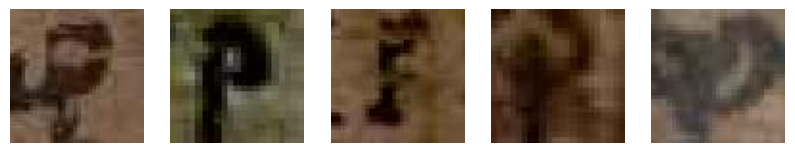

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

# Collect all image files
image_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):  # Check for image formats
            image_files.append(os.path.join(root, file))

print(f"Number of image files found: {len(image_files)}")

# Display some sample images
if len(image_files) > 0:
    print("Displaying sample images...")
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_files[:5]):  # Display first 5 images
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()
else:
    print("No images found.")


# Dynamically Label Images

In [32]:
extract_path = "/content/ALPUB_v2_extracted_new"

# Dynamically locate all image files
image_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

# Extract labels from parent directory names
metadata = []
for img_path in image_files:
    # Infer the label from the parent directory name
    label = os.path.basename(os.path.dirname(img_path))
    metadata.append({
        "image_path": img_path,
        "label": label
    })

# Convert to DataFrame
metadata_df = pd.DataFrame(metadata)

# Save metadata to CSV
metadata_csv_path = "/content/alpub_metadata_dynamic.csv"
metadata_df.to_csv(metadata_csv_path, index=False)

print(f"Metadata saved to: {metadata_csv_path}")
print(metadata_df.head())


Metadata saved to: /content/alpub_metadata_dynamic.csv
                                          image_path label
0  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
1  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
2  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
3  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
4  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho


In [33]:
# Check label distribution
label_counts = metadata_df['label'].value_counts()
print("Label Distribution:")
print(label_counts)


Label Distribution:
label
Omicron        22756
Alpha          21200
Nu             20056
Epsilon        14909
Tau            14817
Iota           13830
Rho            10453
LunateSigma    10151
Pi              9031
Upsilon         8129
Kappa           8110
Omega           7640
Eta             7348
Mu              6924
Lambda          6906
Delta           5689
Chi             4329
Gamma           3721
Theta           3717
Phi             2930
Beta            1296
Zeta             701
Xi               641
Psi              513
Name: count, dtype: int64


In [34]:
# Path to the .txt file
txt_file_path = "/content/ALPUB_v2_extracted_new/alpub_v2_inventory.txt"

# Read and display the first 20 lines
with open(txt_file_path, "r") as file:
    lines = file.readlines()

print("First 20 lines of the .txt file:")
print("".join(lines[:20]))


First 20 lines of the .txt file:
Alpha: 21200
Beta: 1296
Gamma: 3721
Delta: 5689
Epsilon: 14909
Zeta: 701
Eta: 7348
Theta: 3717
Iota: 13830
Kappa: 8110
Lambda: 6906
Mu: 6924
Nu: 20056
Xi: 641
Omicron: 22756
Pi: 9031
Rho: 10453
LunateSigma: 10151
Tau: 14817
Upsilon: 8129



**Augment the Dataset for Balance**

For a more balanced dataset, consider augmenting images for underrepresented classes ( Psi, Xi, Zeta).

Rotation: Rotate images by small angles.

Flipping: Horizontally or vertically flip images.

In [36]:
from PIL import Image, ImageOps
import os
from tqdm import tqdm  # For progress tracking

# Define the underrepresented classes and output directory
underrepresented_classes = ["Psi", "Xi", "Zeta"]
output_dir = "/content/augmented"
os.makedirs(output_dir, exist_ok=True)

# Define augmentations
augmentations = [
    lambda x: x.rotate(15),  # Rotate 15 degrees
    lambda x: ImageOps.mirror(x),  # Flip horizontally
    lambda x: x.crop((10, 10, x.width - 10, x.height - 10)).resize(x.size)  # Crop and resize
]

# Function to augment a single image
def augment_image(image_path, label, output_dir, augmentations):
    img = Image.open(image_path)
    img_name = os.path.basename(image_path)
    for i, aug in enumerate(augmentations):
        augmented_img = aug(img)
        augmented_img.save(os.path.join(output_dir, f"{label}_aug_{i}_{img_name}"))

# Iterate through all images in underrepresented classes
for label in underrepresented_classes:
    print(f"Augmenting images for label: {label}")
    class_images = metadata_df[metadata_df['label'] == label]['image_path'].tolist()
    for img_path in tqdm(class_images):  # Use tqdm for progress tracking
        augment_image(img_path, label, output_dir, augmentations)

print(f"Augmentation completed. Augmented images saved to: {output_dir}")

Augmenting images for label: Psi


100%|██████████| 513/513 [00:00<00:00, 859.53it/s]


Augmenting images for label: Xi


100%|██████████| 641/641 [00:00<00:00, 897.15it/s]


Augmenting images for label: Zeta


100%|██████████| 701/701 [00:00<00:00, 929.99it/s]

Augmentation completed. Augmented images saved to: /content/augmented


In [38]:
# Collect augmented images and update metadata
augmented_metadata = []
for aug_file in os.listdir(output_dir):
    label = aug_file.split("_")[0]  # Extract the label from the filename
    augmented_metadata.append({
        "image_path": os.path.join(output_dir, aug_file),
        "label": label,
        "task": "character_recognition",
        "source": "AL_PUB_v2",
        "augmentation_type": "augmented"
    })

# Convert to DataFrame and append to original metadata
augmented_df = pd.DataFrame(augmented_metadata)
combined_metadata = pd.concat([metadata_df, augmented_df], ignore_index=True)

# Save updated metadata
updated_metadata_path = "/content/combined_metadata_with_augmentation.csv"
combined_metadata.to_csv(updated_metadata_path, index=False)

print(f"Updated metadata saved to: {updated_metadata_path}")


Updated metadata saved to: /content/combined_metadata_with_augmentation.csv


# Merge AL_PUB_v2 Images with Unified Dataset

1. Combine Original and Augmented Metadata
Merge the original metadata from AL_PUB_v2 with the metadata for augmented images.
2. Add Task and Source Columns
Add columns like task, source, and augmentation_type to align with the unified dataset structure.
3. Concatenate with Unified Dataset
Append the combined metadata to your existing unified dataset.

In [39]:
original_metadata_path = "/content/alpub_metadata_dynamic.csv"  # Original AL_PUB_v2 metadata
augmented_metadata_path = "/content/combined_metadata_with_augmentation.csv"  # Augmented metadata
unified_dataset_path = "/content/unified_dataset_with_alpub_v2.csv"  # Unified dataset

# Load metadata files
original_metadata = pd.read_csv(original_metadata_path)
augmented_metadata = pd.read_csv(augmented_metadata_path)
unified_metadata = pd.read_csv(unified_dataset_path)

# Add task, source, and augmentation type columns
original_metadata['task'] = 'character_recognition'
original_metadata['source'] = 'AL_PUB_v2'
original_metadata['augmentation_type'] = 'none'

augmented_metadata['task'] = 'character_recognition'
augmented_metadata['source'] = 'AL_PUB_v2'
augmented_metadata['augmentation_type'] = 'augmented'

# Combine original and augmented metadata
combined_metadata = pd.concat([original_metadata, augmented_metadata], ignore_index=True)

# Append to the unified dataset
final_metadata = pd.concat([unified_metadata, combined_metadata], ignore_index=True)

# Save the updated unified dataset
final_dataset_path = "/content/unified_dataset_final.csv"
final_metadata.to_csv(final_dataset_path, index=False)

print(f"Final unified dataset saved to: {final_dataset_path}")
print(final_metadata.head())

<ipython-input-39-d47a9e013c90>:7: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  augmented_metadata = pd.read_csv(augmented_metadata_path)


Final unified dataset saved to: /content/unified_dataset_final.csv
                                          image_path                   task  \
0  /content/unified_dataset/alpub_v2/Z_POxy.v0043...  character_recognition   
1  /content/unified_dataset/alpub_v2/Z_POxy.v0041...  character_recognition   
2  /content/unified_dataset/alpub_v2/Z_POxy.v0015...  character_recognition   
3  /content/unified_dataset/alpub_v2/Z_POxy.v0018...  character_recognition   
4  /content/unified_dataset/alpub_v2/Z_POxy.v0020...  character_recognition   

      source augmentation_type label  
0  AL_PUB_v2              none   NaN  
1  AL_PUB_v2              none   NaN  
2  AL_PUB_v2              none   NaN  
3  AL_PUB_v2              none   NaN  
4  AL_PUB_v2              none   NaN  


# Datasets so far.

1. **Tiny ImageNet**
Source: Tiny ImageNet dataset.
**Task: Denoising**
Removes noise from images to improve their clarity and restore details.
Size: 100,000 images.
Augmentation Type: none.
2. **COCO (Microsoft Common Objects in Context)**
Source: COCO 2017 dataset.
**Task: Inpainting**
Fills in missing or occluded parts of an image seamlessly.
Size: 100,000 images (randomly selected subset from COCO).
Augmentation Type: none.
3. **DIV2K**
Source: DIV2K (super-resolution benchmark dataset).
**Task: Super-Resolution**
Enhances the resolution of low-resolution images to recover finer details.
Size: 800 image pairs (high-res and downscaled versions).
Augmentation Type: downscaled for low-resolution images.
4. **CIFAR-10**
Source: CIFAR-10 dataset.
**Task: Super-Resolution**
Enhances the resolution of low-resolution images.
Size: 50,000 images (original dataset).
Augmentation Type: downscaled.
5. **CIFAR-100**
Source: CIFAR-100 dataset.
**Task: Super-Resolution**
Enhances the resolution of low-resolution images.
Size: 50,000 images (original dataset).
Augmentation Type: downscaled.
6. **AL_PUB_v2** (Ancient Greek Characters Dataset)
Source: AL_PUB_v2 dataset from Kaggle.
**Task: Character Recognition**
Recognizes and classifies individual ancient Greek characters.
Size:
Original: 205,797 images across 24 Greek character classes.

**Augmented:** Additional images for underrepresented classes (Psi, Xi, Zeta) using techniques like rotation, flipping, and cropping.
Augmentation Type: none for originals, augmented for augmented images.

In [43]:
# Final unified dataset
final_metadata_path = "/content/unified_dataset_final.csv"
final_metadata = pd.read_csv(final_metadata_path)

# --------------------------------
# 1. Total number of images
# --------------------------------

total_images = len(final_metadata)
print(f"Total number of images: {total_images}")

# --------------------------------
# 2. Label distribution
# --------------------------------

label_distribution = final_metadata['label'].value_counts()
print("\nLabel Distribution:")
print(label_distribution)

# --------------------------------
# 3. Task distribution
# --------------------------------

task_distribution = final_metadata['task'].value_counts()
print("\nTask Distribution:")
print(task_distribution)

# --------------------------------
# 4. Source distribution
# --------------------------------

source_distribution = final_metadata['source'].value_counts()
print("\nSource Distribution:")
print(source_distribution)

# --------------------------------
# 5. Augmentation type distribution
# --------------------------------
augmentation_distribution = final_metadata['augmentation_type'].value_counts()
print("\nAugmentation Type Distribution:")
print(augmentation_distribution)

# --------------------------------
# Optional: Save all statistics to a CSV for easy reference
# --------------------------------
statistics = {
    "Label Distribution": label_distribution,
    "Task Distribution": task_distribution,
    "Source Distribution": source_distribution,
    "Augmentation Type Distribution": augmentation_distribution
}
statistics_df = pd.DataFrame({key: value for key, value in statistics.items()})
statistics_df.to_csv("/content/unified_dataset_statistics.csv", index=True)
print("Statistics saved to: /content/unified_dataset_statistics.csv")


<ipython-input-43-5f38ec2ecf94>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  final_metadata = pd.read_csv(final_metadata_path)


Total number of images: 622956

Label Distribution:
label
Omicron        45512
Alpha          42400
Nu             40112
Epsilon        29818
Tau            29634
Iota           27660
Rho            20906
LunateSigma    20302
Pi             18062
Upsilon        16258
Kappa          16220
Omega          15280
Eta            14696
Mu             13848
Lambda         13812
Delta          11378
Chi             8658
Gamma           7442
Theta           7434
Phi             5860
Zeta            3505
Xi              3205
Beta            2592
Psi             2565
Name: count, dtype: int64

Task Distribution:
task
character_recognition    622956
Name: count, dtype: int64

Source Distribution:
source
AL_PUB_v2    622956
Name: count, dtype: int64

Augmentation Type Distribution:
augmentation_type
none         411594
augmented    211362
Name: count, dtype: int64
Statistics saved to: /content/unified_dataset_statistics.csv


In [44]:
import pandas as pd

# Path to the file
balanced_dataset_path = "/content/unified_dataset_balanced.csv"

# Load the dataset
balanced_metadata = pd.read_csv(balanced_dataset_path)

# Inspect the first few rows
print("Sample rows from the balanced dataset:")
print(balanced_metadata.head())

# Total number of images
total_images = len(balanced_metadata)
print(f"\nTotal number of images: {total_images}")

# Task distribution
if "task" in balanced_metadata.columns:
    task_distribution = balanced_metadata['task'].value_counts()
    print("\nTask Distribution:")
    print(task_distribution)

# Source distribution
if "source" in balanced_metadata.columns:
    source_distribution = balanced_metadata['source'].value_counts()
    print("\nSource Distribution:")
    print(source_distribution)

# Augmentation type distribution
if "augmentation_type" in balanced_metadata.columns:
    augmentation_distribution = balanced_metadata['augmentation_type'].value_counts()
    print("\nAugmentation Type Distribution:")
    print(augmentation_distribution)


Sample rows from the balanced dataset:
                                          image_path       task  \
0  /content/unified_dataset/tiny_imagenet_n037062...  denoising   
1  /content/unified_dataset/tiny_imagenet_n037062...  denoising   
2  /content/unified_dataset/tiny_imagenet_n037062...  denoising   
3  /content/unified_dataset/tiny_imagenet_n037062...  denoising   
4  /content/unified_dataset/tiny_imagenet_n037062...  denoising   

          source augmentation_type  
0  Tiny ImageNet              none  
1  Tiny ImageNet              none  
2  Tiny ImageNet              none  
3  Tiny ImageNet              none  
4  Tiny ImageNet              none  

Total number of images: 200000

Task Distribution:
task
denoising     100000
inpainting    100000
Name: count, dtype: int64

Source Distribution:
source
Tiny ImageNet    100000
COCO             100000
Name: count, dtype: int64

Augmentation Type Distribution:
augmentation_type
none    200000
Name: count, dtype: int64


In [45]:
import pandas as pd

# List of all potential CSV files in your directory
csv_files = [
    "/content/alpub_metadata.csv",
    "/content/alpub_metadata_dynamic.csv",
    "/content/combined_metadata_with_augmentation.csv",
    "/content/unified_dataset_balanced.csv",
    "/content/unified_dataset_final.csv",
    "/content/unified_dataset_with_alpub_v2.csv",
    "/content/unified_dataset_statistics.csv"
]

# Iterate through all files and print summaries
for file_path in csv_files:
    try:
        print(f"Inspecting file: {file_path}")
        data = pd.read_csv(file_path)

        # Print basic statistics
        print(f"File: {file_path}")
        print(f"Number of rows: {len(data)}")
        print(f"Number of columns: {len(data.columns)}")
        print(f"Columns: {data.columns.tolist()}")
        print(f"Sample rows:\n{data.head()}")
        print("-" * 40)
    except Exception as e:
        print(f"Could not process {file_path}. Error: {e}")


Inspecting file: /content/alpub_metadata.csv
File: /content/alpub_metadata.csv
Number of rows: 0
Number of columns: 3
Columns: ['image_path', 'label', 'class_name']
Sample rows:
Empty DataFrame
Columns: [image_path, label, class_name]
Index: []
----------------------------------------
Inspecting file: /content/alpub_metadata_dynamic.csv
File: /content/alpub_metadata_dynamic.csv
Number of rows: 205797
Number of columns: 2
Columns: ['image_path', 'label']
Sample rows:
                                          image_path label
0  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
1  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
2  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
3  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
4  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho
----------------------------------------
Inspecting file: /content/combined_metadata_with_augmentation.csv


<ipython-input-45-d35d70016308>:18: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


File: /content/combined_metadata_with_augmentation.csv
Number of rows: 211362
Number of columns: 5
Columns: ['image_path', 'label', 'task', 'source', 'augmentation_type']
Sample rows:
                                          image_path label task source  \
0  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho  NaN    NaN   
1  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho  NaN    NaN   
2  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho  NaN    NaN   
3  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho  NaN    NaN   
4  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...   Rho  NaN    NaN   

  augmentation_type  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
----------------------------------------
Inspecting file: /content/unified_dataset_balanced.csv
File: /content/unified_dataset_balanced.csv
Number of rows: 200000
Number of columns: 4
Columns: ['image_path', 'task', 'source', 'augmentation

<ipython-input-45-d35d70016308>:18: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


File: /content/unified_dataset_final.csv
Number of rows: 622956
Number of columns: 5
Columns: ['image_path', 'task', 'source', 'augmentation_type', 'label']
Sample rows:
                                          image_path                   task  \
0  /content/unified_dataset/alpub_v2/Z_POxy.v0043...  character_recognition   
1  /content/unified_dataset/alpub_v2/Z_POxy.v0041...  character_recognition   
2  /content/unified_dataset/alpub_v2/Z_POxy.v0015...  character_recognition   
3  /content/unified_dataset/alpub_v2/Z_POxy.v0018...  character_recognition   
4  /content/unified_dataset/alpub_v2/Z_POxy.v0020...  character_recognition   

      source augmentation_type label  
0  AL_PUB_v2              none   NaN  
1  AL_PUB_v2              none   NaN  
2  AL_PUB_v2              none   NaN  
3  AL_PUB_v2              none   NaN  
4  AL_PUB_v2              none   NaN  
----------------------------------------
Inspecting file: /content/unified_dataset_with_alpub_v2.csv
File: /content/unifi

**Confirm CIFAR-10 and CIFAR-100**

In [55]:
cifar10_hr_path = "/content/data/cifar/cifar10_hr"
cifar100_lr_path = "/content/data/cifar/cifar100_lr"

# Check if directories exist and list contents if they do
paths_to_check = {
    "CIFAR-10 High-Resolution Path": cifar10_hr_path,
    "CIFAR-100 Low-Resolution Path": cifar100_lr_path
}

for description, path in paths_to_check.items():
    if os.path.exists(path):
        print(f"{description}: Found")
        print(f"Sample files: {os.listdir(path)[:5]}")
    else:
        print(f"{description}: Path does not exist")


CIFAR-10 High-Resolution Path: Found
Sample files: ['23632_hr.png', '28766_hr.png', '33820_hr.png', '46445_hr.png', '6125_hr.png']
CIFAR-100 Low-Resolution Path: Found
Sample files: ['17979_lr.png', '16583_lr.png', '47045_lr.png', '36395_lr.png', '33339_lr.png']


# Datasets and Paths

**Tiny ImageNet (Denoising Task)**

Path: /content/unified_dataset/tiny_imagenet_*

**COCO Dataset (Inpainting Task)**

Path: /content/unified_dataset/coco_*

**AL_PUB_v2 Dataset (Character Recognition Task)**

Original Images Path: /content/unified_dataset/alpub_v2/

Augmented Images Path: /content/unified_dataset/augmented_alpub_v2/

**DIV2K Dataset (Super-Resolution Task)**

High-Resolution Images Path: /content/data/DIV2K/DIV2K_train_HR
Low-Resolution Images Path: /content/unified_dataset/super_resolution_lr

**CIFAR-10 Dataset (Super-Resolution Task)**

High-Resolution Images Path: /content/data/cifar/cifar10_hr

**CIFAR-100 Dataset (Super-Resolution Task)**

Low-Resolution Images Path: /content/data/cifar/cifar100_lr

In [56]:
# Paths to metadata sources
tiny_imagenet_metadata_path = "/content/unified_dataset_balanced.csv"  # Tiny ImageNet + COCO
alpub_metadata_path = "/content/combined_metadata_with_augmentation.csv"  # AL_PUB_v2
div2k_metadata_path = "/content/div2k_metadata.csv"  # DIV2K
cifar10_metadata_path = "/content/data/cifar/cifar10_hr"  # CIFAR-10 HR
cifar100_metadata_path = "/content/data/cifar/cifar100_lr"  # CIFAR-100 LR

# --------------------------------
# Step 1: Load all metadata files
# --------------------------------
# Load existing metadata
tiny_imagenet_metadata = pd.read_csv(tiny_imagenet_metadata_path)
alpub_metadata = pd.read_csv(alpub_metadata_path)
div2k_metadata = pd.read_csv(div2k_metadata_path)

# Create metadata for CIFAR-10 and CIFAR-100 if not already done
cifar_metadata = []

# CIFAR-10 (High Resolution)
for img_file in os.listdir(cifar10_metadata_path):
    cifar_metadata.append({
        "image_path": os.path.join(cifar10_metadata_path, img_file),
        "task": "super_resolution",
        "source": "CIFAR-10",
        "augmentation_type": "none",
    })

# CIFAR-100 (Low Resolution)
for img_file in os.listdir(cifar100_metadata_path):
    cifar_metadata.append({
        "image_path": os.path.join(cifar100_metadata_path, img_file),
        "task": "super_resolution",
        "source": "CIFAR-100",
        "augmentation_type": "none",
    })

# Convert CIFAR metadata to a DataFrame
cifar_metadata_df = pd.DataFrame(cifar_metadata)

# --------------------------------
# Step 2: Merge all metadata
# --------------------------------
# Combine all datasets into one unified dataframe
final_dataset = pd.concat([tiny_imagenet_metadata, alpub_metadata, div2k_metadata, cifar_metadata_df], ignore_index=True)

# --------------------------------
# Step 3: Save the unified dataset
# --------------------------------
final_dataset_path = "/content/final_dataset.csv"
final_dataset.to_csv(final_dataset_path, index=False)

# --------------------------------
# Step 4: Display statistics
# --------------------------------
print(f"Unified dataset saved to: {final_dataset_path}")
print(f"Total number of images: {len(final_dataset)}")
print("Sample rows from the unified dataset:")
print(final_dataset.sample(5))

# Statistics
print("\nTask Distribution:")
print(final_dataset['task'].value_counts())
print("\nSource Distribution:")
print(final_dataset['source'].value_counts())
print("\nAugmentation Type Distribution:")
print(final_dataset['augmentation_type'].value_counts())


<ipython-input-56-4b08a2c9c310>:13: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  alpub_metadata = pd.read_csv(alpub_metadata_path)


Unified dataset saved to: /content/final_dataset.csv
Total number of images: 512162
Sample rows from the unified dataset:
                                               image_path              task  \
203885  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...               NaN   
328473  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...               NaN   
76158   /content/unified_dataset/tiny_imagenet_n030147...         denoising   
433898        /content/data/cifar/cifar10_hr/18792_hr.png  super_resolution   
338957  /content/ALPUB_v2_extracted_new/ALPUB_v2/image...               NaN   

               source augmentation_type    label  
203885            NaN               NaN      Rho  
328473            NaN               NaN  Omicron  
76158   Tiny ImageNet              none      NaN  
433898       CIFAR-10              none      NaN  
338957            NaN               NaN       Mu  

Task Distribution:
task
super_resolution         100800
denoising                100000
inpainti

# Next Steps: Fix Missing Metadata:

1. Address rows with missing values in the task and source columns (likely from AL_PUB_v2).

2. Assign character_recognition to missing task and AL_PUB_v2 to missing source.

3. For character_recognition, analyze the distribution of labels (e.g., Greek characters).

4. Finalize Dataset: Ensure all metadata is consistent and ready for model training.
